In [1]:
pip install alpha-vantage

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

API_KEY = 'JY46FF8BN6CNDH5Z'

In [3]:
ts = TimeSeries(key=API_KEY, output_format='pandas')
# Get DataFrame object with the intraday data and another with  the call's metadata
dataset_train, meta_dataset_train = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
dataset_train.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2024-08-09 19:59:00,406.53,406.700,406.5,406.700,262.0
2024-08-09 19:58:00,406.55,406.700,406.4,406.525,735.0
2024-08-09 19:57:00,406.70,406.700,406.4,406.640,43.0
2024-08-09 19:56:00,406.55,406.700,406.4,406.550,93.0
2024-08-09 19:55:00,406.40,406.699,406.4,406.550,58.0


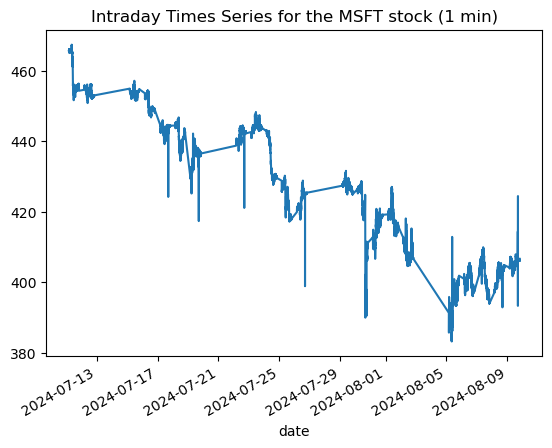

In [4]:
dataset_train['4. close'].plot()
plt.title('Intraday Times Series for the MSFT stock (1 min)')
plt.show()

In [5]:
print(dataset_train.head())

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2024-08-09 19:59:00   406.53  406.700   406.5   406.700      262.0
2024-08-09 19:58:00   406.55  406.700   406.4   406.525      735.0
2024-08-09 19:57:00   406.70  406.700   406.4   406.640       43.0
2024-08-09 19:56:00   406.55  406.700   406.4   406.550       93.0
2024-08-09 19:55:00   406.40  406.699   406.4   406.550       58.0


In [6]:
training_set = dataset_train.iloc[:, 0:1].values

print(training_set)
print(training_set.shape)

[[406.53]
 [406.55]
 [406.7 ]
 ...
 [465.71]
 [465.82]
 [465.95]]
(21057, 1)


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = scaler.fit_transform(training_set)

scaled_training_set

array([[0.27713571],
       [0.277374  ],
       [0.27916121],
       ...,
       [0.98224711],
       [0.98355773],
       [0.98510664]])

In [8]:
x_train = []
y_train = []

for i in range(60, len(scaled_training_set)):
    x_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(20997, 60)
(20997,)


In [9]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(20997, 60, 1)

In [10]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

c:\Users\mafer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step - loss: 0.0146
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - loss: 0.0021
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - loss: 0.0017
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - loss: 0.0013
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - loss: 0.0011
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - loss: 9.1520e-04
Epoch 7/100
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 8.3465e-04

KeyboardInterrupt: 